In [1]:
# Check if we are running on Kaggle
import os

PATH = ""

if "KAGGLE_URL_BASE" in os.environ:
    print("Running on Kaggle")
    PATH = "/kaggle/input/gemastik-review-puskesmas/"

Running on Kaggle


# Data Load

In [2]:
import pandas as pd

data_puskesmas = pd.read_csv(f"{PATH}preprocessed-review.csv")
data_puskesmas.head()

,reviewer_name,rating,review_text,puskesmas_name,cleaned_review_text,language
0,Mira Diah V,5,Pelayanan di poli KIA bagus&informatif sekali....,Puskesmas Simomulyo,layan pol kia bagusinformatif anak imunisasi a...,id
1,Ranitya Dewi Ayu Sadian,1,Pelayanan poli KIA lama sekali…\nKamis pagi se...,Puskesmas Simomulyo,layan pol kia kamis pagi puskesmas daftar pol ...,id
2,Mas Bri,4,Menurut saya sudah bagus untuk mau yang mau be...,Puskesmas Simomulyo,bagus obat daftar onlen alamat website mudah c...,id
3,Yuliasti Ika,5,"Puskesmas dengan pelayanan yang baik sekali, s...",Puskesmas Simomulyo,puskesmas layan layan ramah lengkap fasilitas ...,id
4,Yusup Jaya,1,"Pelayanan tambah lelet, mohon managentnya di p...",Puskesmas Simomulyo,layan lambat mohon managernya sat set rujuk ce...,id


In [3]:
train_data = data_puskesmas[
    (data_puskesmas["rating"] == 5) | (data_puskesmas["rating"] == 1)
]
test_data = data_puskesmas[
    (data_puskesmas["rating"] != 5) & (data_puskesmas["rating"] != 1)
]

print("train_data.shape:", train_data.shape)
print("test_data.shape:", test_data.shape)

train_data.shape: (7808, 6)
test_data.shape: (1218, 6)


test data adalah data yang tidak jelas dia tergolong positif atau negatif, sehingga kita perlu melakukan prediksi terhadap data tersebut. Karena data tersebut berkisar antara rating 1-5, maka kita akan menggunakan model klasifikasi untuk memprediksi data tersebut.

In [4]:
# make the rating 5 as 1 and the rating 1 as 0
train_data["is_positive"] = train_data["rating"].apply(lambda x: 1 if x == 5 else 0)

print(train_data["is_positive"].value_counts())

is_positive
1    4953
0    2855
Name: count, dtype: int64


/tmp/ipykernel_34/1439492560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["is_positive"] = train_data["rating"].apply(lambda x: 1 if x == 5 else 0)


In [5]:
from sklearn.model_selection import train_test_split

train_data_resample, val_data = train_test_split(
    train_data, test_size=0.2, random_state=42, stratify=train_data["is_positive"], shuffle=True
)

val_data, eval_data = train_test_split(
    val_data, test_size=0.5, random_state=42, stratify=val_data["is_positive"], shuffle=True
)

print("train_data_resample.shape:", train_data_resample.shape)
print("val_data.shape:", val_data.shape)
print("eval_data.shape:", eval_data.shape)

train_data_resample.shape: (6246, 7)
val_data.shape: (781, 7)
eval_data.shape: (781, 7)


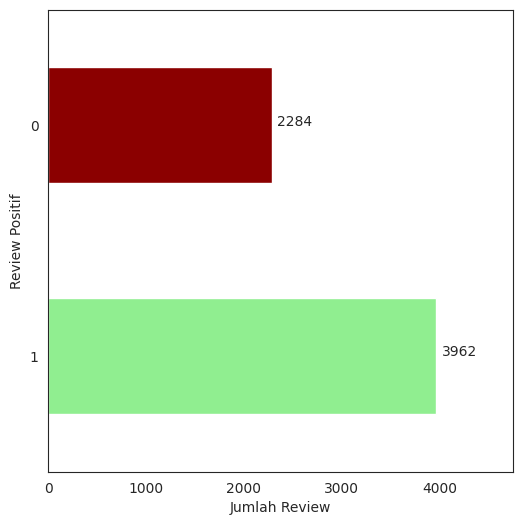

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_palette("muted")

plt.figure(figsize=(6, 6))
counts = train_data_resample["is_positive"].value_counts()
counts.plot(kind="barh", color=["#90EE90", "#8B0000"])

for index, value in enumerate(counts):
    plt.text(value + 60, index, str(value))

plt.xlabel("Jumlah Review")
plt.ylabel("Review Positif")

plt.xlim(0, max(counts) * 1.2)

plt.show()

In [7]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(
    train_data_resample, train_data_resample["is_positive"]
)

train_data_resample = pd.DataFrame(X_resampled, columns=train_data.columns)

print(train_data_resample["is_positive"].value_counts())

is_positive
0    2284
1    2284
Name: count, dtype: int64


nanti datanya akan dicombine ulang untuk analsis lebih lanjut

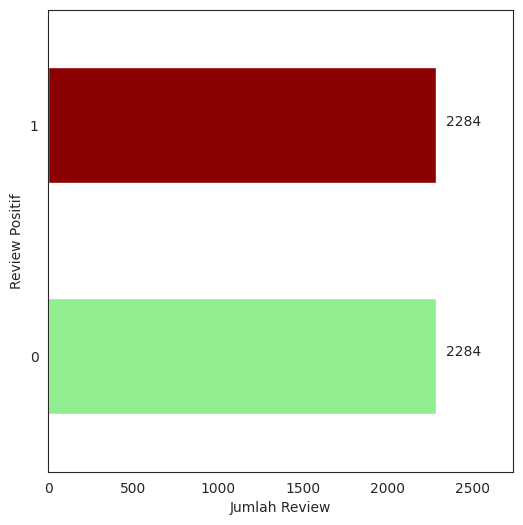

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_palette("muted")

plt.figure(figsize=(6, 6))
counts = train_data_resample["is_positive"].value_counts()
counts.plot(kind="barh", color=["#90EE90", "#8B0000"])

for index, value in enumerate(counts):
    plt.text(value + 60, index, str(value))

plt.xlabel("Jumlah Review")
plt.ylabel("Review Positif")

plt.xlim(0, max(counts) * 1.2)

plt.show()

# Model Building

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_resample.review_text)

word_idx, vocab_size = tokenizer.word_index, len(tokenizer.word_index) + 1

print("vocab_size:", vocab_size)

2024-06-28 06:44:14.167203: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 06:44:14.167293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 06:44:14.326742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


vocab_size: 10955


In [10]:
from keras.preprocessing.sequence import pad_sequences

# convert text data to sequences
text_sequences_train = tokenizer.texts_to_sequences(train_data_resample.review_text)
text_sequences_val = tokenizer.texts_to_sequences(val_data.review_text)
text_sequences_eval = tokenizer.texts_to_sequences(eval_data.review_text)

# pad the sequences
max_length = max([len(sequence) for sequence in text_sequences_train])

text_sequences_train = pad_sequences(text_sequences_train, maxlen=max_length)
text_sequences_val = pad_sequences(text_sequences_val, maxlen=max_length)
text_sequences_eval = pad_sequences(text_sequences_eval, maxlen=max_length)

print("text_sequences_train.shape:", text_sequences_train.shape)
print("text_sequences_val.shape:", text_sequences_val.shape)

text_sequences_train.shape: (4568, 585)
text_sequences_val.shape: (781, 585)


In [11]:
y_train = train_data_resample.is_positive
y_val = val_data.is_positive
y_eval = eval_data.is_positive

print("y_train.shape:", y_train.shape)
print("y_val.shape:", y_val.shape)

y_train.shape: (4568,)
y_val.shape: (781,)


In [12]:
import os

file_path = "cc.id.300.bin"

if not os.path.exists(file_path):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz -O cc.id.300.bin.gz -q
    !gunzip cc.id.300.bin.gz

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [13]:
import numpy as np
from fasttext import FastText
from tqdm.notebook import tqdm

ft = FastText.load_model("cc.id.300.bin")

embedding_matrix = np.zeros((vocab_size, 300))

for word, idx in tqdm(word_idx.items()):
    embedding_vec = ft.get_word_vector(word)
    if embedding_vec is not None:
        embedding_matrix[idx] = embedding_vec

  0%|          | 0/10954 [00:00<?, ?it/s]

In [14]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

tf.random.set_seed(42)

embbeding_layer = tf.keras.layers.Embedding(
    vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Bidirectional, GlobalAvgPool1D, BatchNormalization
from tensorflow.keras.optimizers import Adam

sequence_input = tf.keras.layers.Input(shape=(max_length,), dtype="int32")
embedded_sequences = embbeding_layer(sequence_input)

lstm = Bidirectional(
    LSTM(256, return_sequences=True)
    )(embedded_sequences)

pooled_output = GlobalAvgPool1D()(lstm)

dense = Dense(256, activation="relu")(pooled_output)
dropout = Dropout(0.5)(dense)

output = Dense(1, activation="sigmoid")(dropout)

model = tf.keras.Model(sequence_input, output)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

model.compile(
    loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"]
)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 585)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 585, 300)       │     3,286,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 585, 512)       │     1,140,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,558,821 (17.39 MB)

 Trainable params: 1,272,321 (4.85 MB)

 Non-trainable params: 3,286,500 (12.54 MB)

In [18]:
history = model.fit(
    text_sequences_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_data=(text_sequences_val, y_val),
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.6780 - loss: 0.6388 - val_accuracy: 0.8003 - val_loss: 0.4966 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.7855 - loss: 0.4841 - val_accuracy: 0.8348 - val_loss: 0.3915 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.8261 - loss: 0.4723 - val_accuracy: 0.8348 - val_loss: 0.4314 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.8300 - loss: 0.4302 - val_accuracy: 0.8579 - val_loss: 0.3186 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.8320 - loss: 0.4169 - val_accuracy: 0.8681 - val_loss: 0.3406 - learning_rate: 0.0010
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8603 - loss: 0.3732
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.8602 - loss: 0.3734 -

In [19]:
print("Training Accuracy:", max(history.history["accuracy"]))
print("Validation Accuracy:", max(history.history["val_accuracy"]))

Training Accuracy: 0.8515762090682983
Validation Accuracy: 0.8681178092956543


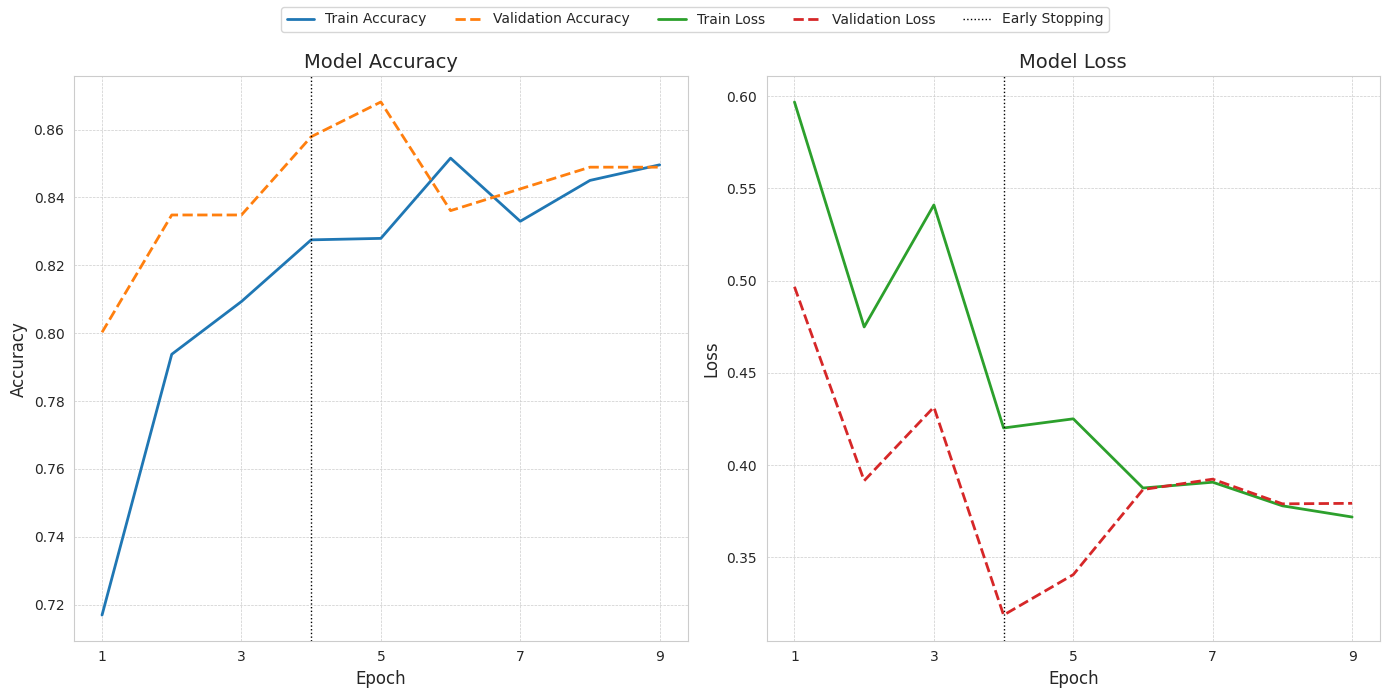

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

sns.set_style("whitegrid")
sns.set_palette("muted")

best_epoch = early_stopping.stopped_epoch - early_stopping.patience + 1
num_epochs = len(history.history["accuracy"])

plt.figure(figsize=(14, 7))

# Accuracy subplot
ax1 = plt.subplot(1, 2, 1)
ax1.plot(range(1, num_epochs + 1), history.history["accuracy"], label="Train Accuracy", color="tab:blue", linewidth=2)
ax1.plot(range(1, num_epochs + 1), history.history["val_accuracy"], label="Validation Accuracy", color="tab:orange", linewidth=2, linestyle='--')
ax1.set_title("Model Accuracy", fontsize=14)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.set_xticks(range(1, num_epochs + 1, 2))
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Loss subplot
ax2 = plt.subplot(1, 2, 2)
ax2.plot(range(1, num_epochs + 1), history.history["loss"], label="Train Loss", color="tab:green", linewidth=2)
ax2.plot(range(1, num_epochs + 1), history.history["val_loss"], label="Validation Loss", color="tab:red", linewidth=2, linestyle='--')
ax2.set_title("Model Loss", fontsize=14)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Loss", fontsize=12)
ax2.set_xticks(range(1, num_epochs + 1, 2))
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

for ax in [ax1, ax2]:
    ax.axvline(best_epoch, color="black", linestyle=":", linewidth=1, label="Early Stopping")

legend_handles = [
    Line2D([0], [0], color="tab:blue", linewidth=2, label="Train Accuracy"),
    Line2D([0], [0], color="tab:orange", linewidth=2, linestyle='--', label="Validation Accuracy"),
    Line2D([0], [0], color="tab:green", linewidth=2, label="Train Loss"),
    Line2D([0], [0], color="tab:red", linewidth=2, linestyle='--', label="Validation Loss"),
    Line2D([0], [0], color="black", linestyle=":", linewidth=1, label="Early Stopping")
]

plt.figlegend(handles=legend_handles, loc="upper center", ncol=5, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
              precision    recall  f1-score   support

    Negative       0.86      0.81      0.84       286
    Positive       0.90      0.93      0.91       495

    accuracy                           0.88       781
   macro avg       0.88      0.87      0.87       781
weighted avg       0.88      0.88      0.88       781

Accuracy: 0.8847631241997439


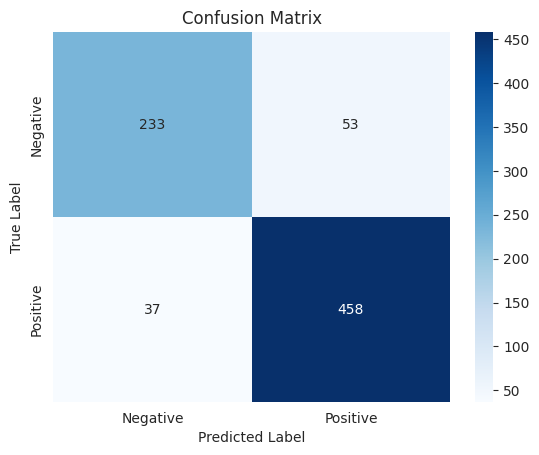

In [21]:
y_eval_pred = model.predict(text_sequences_eval)
y_eval_pred = np.round(y_eval_pred).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from seaborn import heatmap
from matplotlib import pyplot as plt

print(classification_report(y_eval, y_eval_pred, target_names=["Negative", "Positive"]))
print("Accuracy:", accuracy_score(y_eval, y_eval_pred))

cm = confusion_matrix(y_eval, y_eval_pred)

heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()